In [115]:
!pip install unidecode
!pip install folium geopy
!pip install scikit-surprise
#from google.colab import drive
#drive.mount('/content/drive')
#!cp /content/drive/MyDrive/3-PROYECTO_FINAL/funciones_usisa.py /content
#!cp /content/drive/MyDrive/3-PROYECTO_FINAL/tienda_online_antiguo.xlsx /content
#!cp /content/drive/MyDrive/3-PROYECTO_FINAL/tienda_online_nuevo.csv /content

import folium
from geopy.geocoders import Nominatim
import pandas as pd
import re
import numpy as np
from math import pi
import datetime
from datetime import datetime, timedelta
from unidecode import unidecode
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
#FUNCIONES
from funciones_usisa import *
#VISUALIZACION
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
#MODELOS
from statsmodels.tsa.api import SARIMAX
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.cluster import DBSCAN
from sklearn.metrics import mean_squared_error, mean_absolute_error
import itertools
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import accuracy
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

df_new = pd.read_csv("tienda_online_nuevo.csv", encoding = "ISO-8859-1")
df_antiguo = pd.read_excel("tienda_online_antiguo.xlsx")

In [116]:
df_nuevo=todas_las_funciones_nuevo_postal(df_new) #DATAFRAME CON LOS DATOS DE LA BASE DE DATOS NUEVA
df=todas_las_funciones_historico(df_antiguo, todas_las_funciones_nuevo_postal(df_new)) #UNIÓN DE LA BASE DE DATOS NUEVA CON LA ANTIGUA

# **PREPROCESAMIENTO DE LOS DATOS**

In [117]:
df_nuevo_cliente=limpiar_cliente(df_nuevo.copy()) #APLICAR FUNCIÓN PARA LA LIMPIEZA DEL NUEVO
df_nuevo_cliente.rename(columns={"total_price_tax_incl": "precio_total"}, inplace=True)

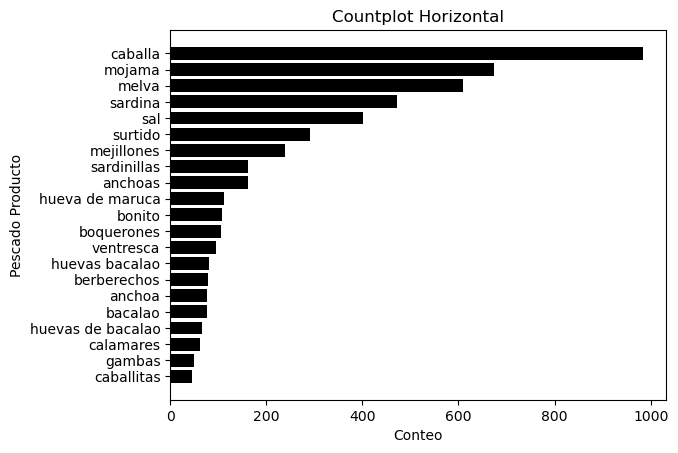

In [118]:
#GRÁFICO CON EL CONTEO DE LOS PRODUCTOS POR TIPO DE PESCADO
counts = df_nuevo['pescado'].value_counts().sort_values()

plt.barh(counts.index, counts, color="k")

plt.xlabel('Conteo')
plt.ylabel('Pescado Producto')
plt.title('Countplot Horizontal')

plt.show()

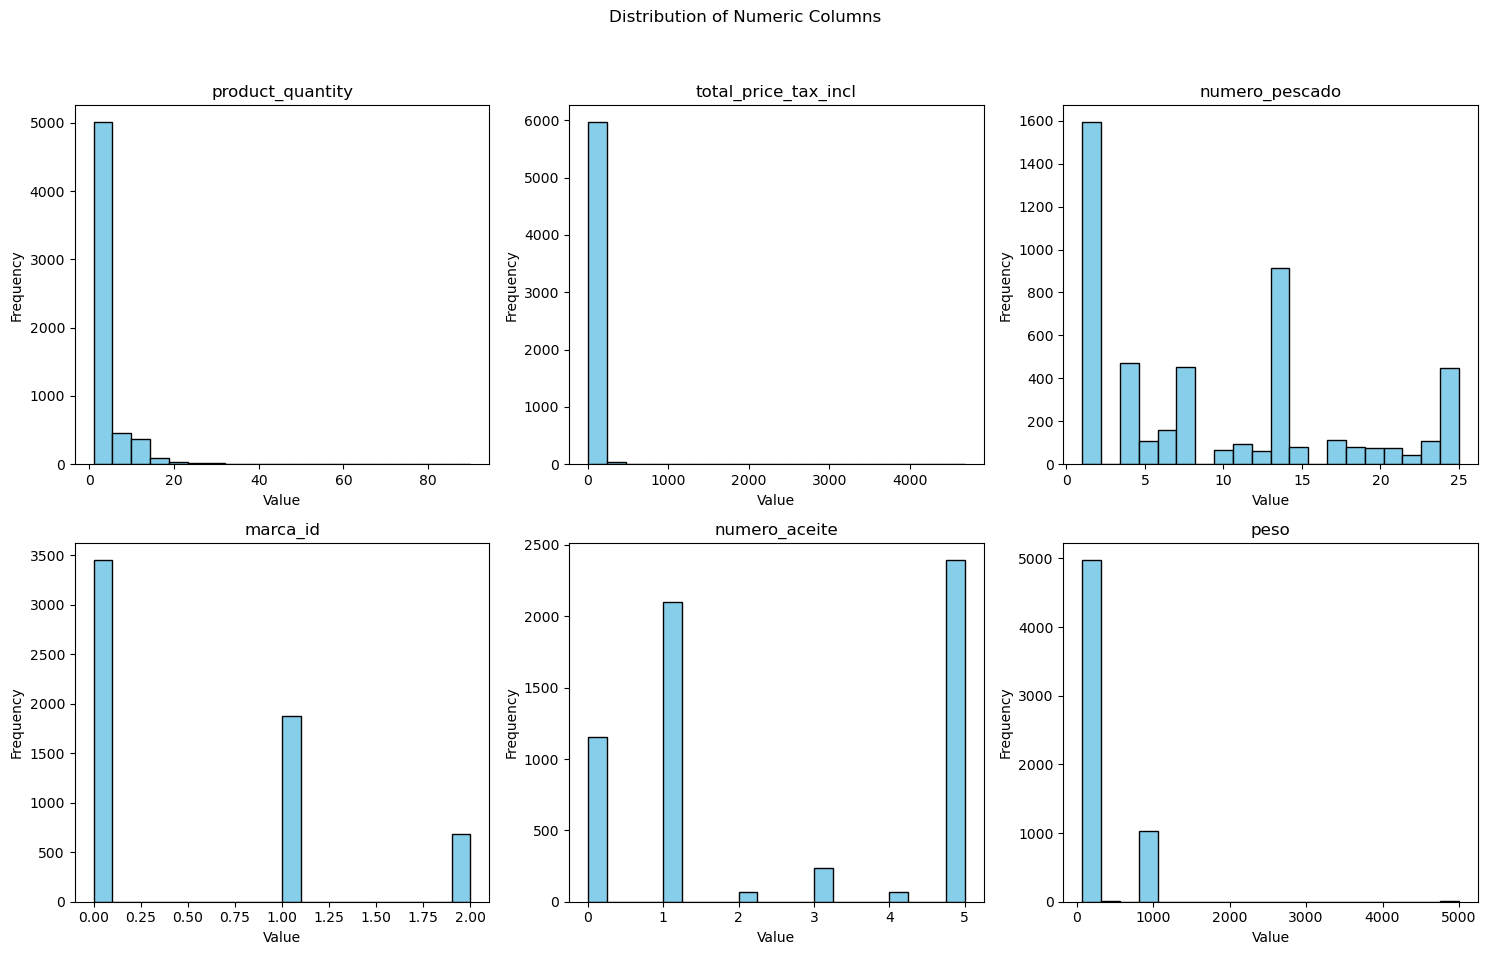

In [119]:
#SUBPLOTS DE LAS VARIABLES
columnas_para_plot=['product_quantity','total_price_tax_incl', 'numero_pescado', 'marca_id', 'numero_aceite','peso']
df_subplots=df_nuevo[columnas_para_plot]
num_columns = df_subplots.shape[1]
num_rows = int(num_columns**0.5)
num_cols = (num_columns + num_rows - 1) // num_rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
fig.suptitle('Distribution of Numeric Columns')

axes = axes.flatten()

for i, col in enumerate(df_subplots.columns):
    axes[i].hist(df_subplots[col].dropna(), bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(col)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')


plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()


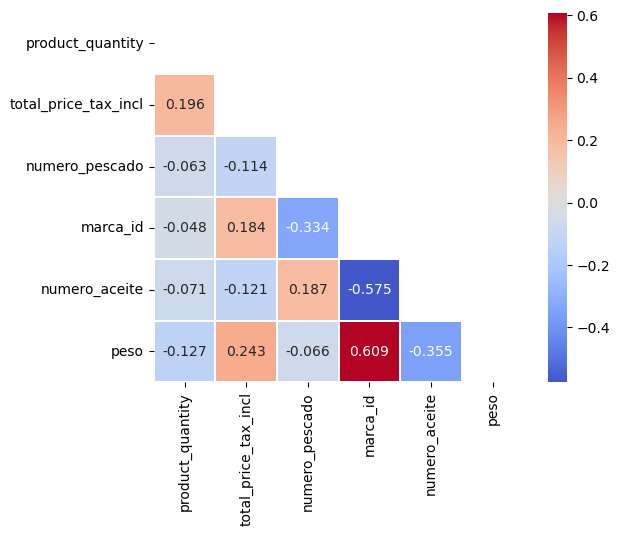

In [120]:
#MAPA DE CALOR PRINCIPALES VARIABLES
heatmap_triu(df_nuevo[columnas_para_plot])


# **ANÁLISIS DE DATOS EXPLORATORIO**

In [121]:
#SUBPLOTS DE ["id_pescado", "id_marca", "id_aceite", "peso"] LAS QUE UTILIZAREMOS PARA EL CLUSTERING
df_final=frecuencia_nuevo(df_nuevo_cliente)
columnas_modelo=["ultima_compra",'conteo', 'precio_total_cliente']

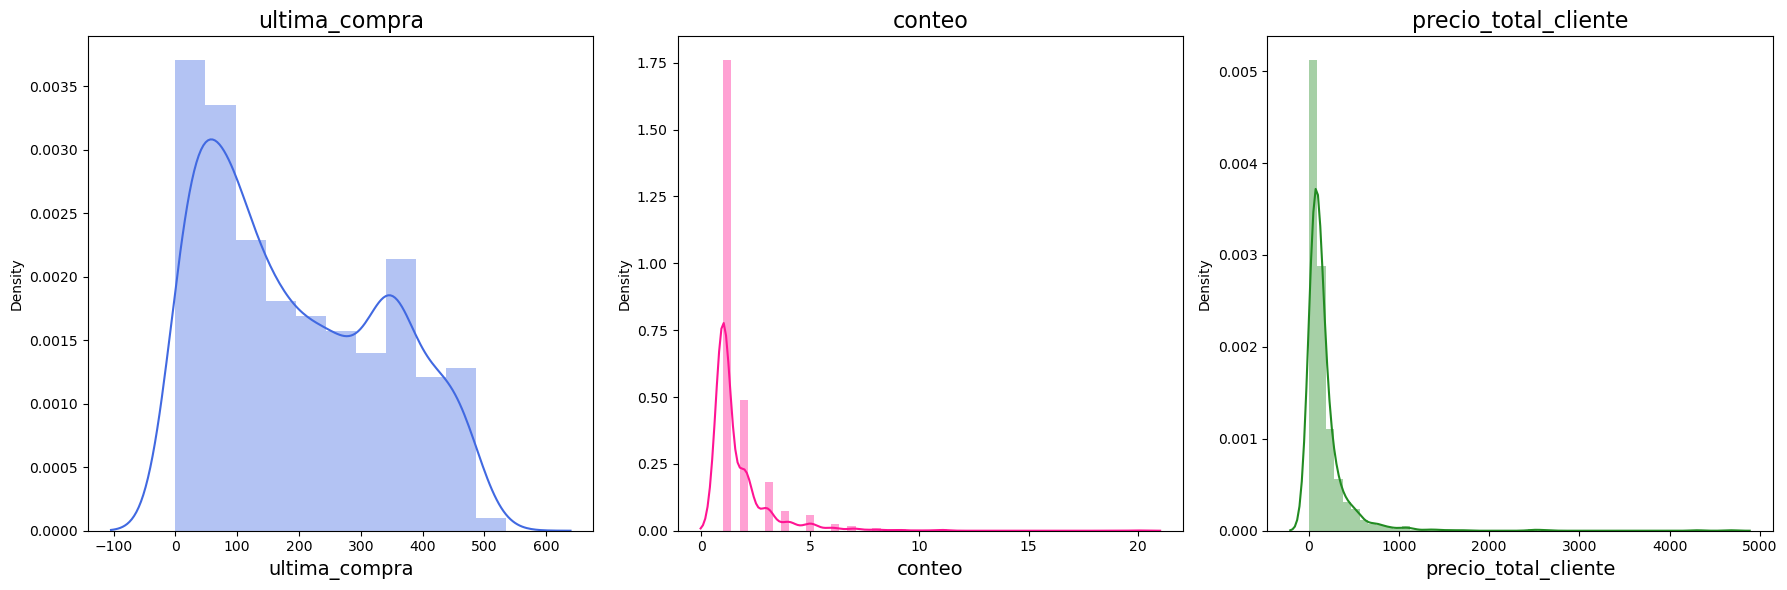

In [122]:
colors = ['royalblue', 'deeppink', 'forestgreen']

plt.figure(figsize=(18, 6))

for i, col in enumerate(columnas_modelo, start=1):
    plt.subplot(1, 3, i)
    sns.distplot(df_final[col], color=colors[i-1])
    plt.title(col, fontsize=16)
    plt.xlabel(col, fontsize=14)

plt.tight_layout()
plt.show()


# **MAPA CON LA GEOLOCALIZACIÓN DE PEDIDOS**

In [123]:
df_mapa=df_final[["conteo", "codigo_postal"]].copy()
df_mapa_unicos=df_mapa.groupby("codigo_postal")["conteo"].sum().reset_index()

In [124]:
dicc_mapa=dict(zip(df_mapa["codigo_postal"], df_mapa["conteo"]))

In [125]:
def crear_mapa(dicciona, color):
    mapa = folium.Map(location=[40.416775, -3.703790], zoom_start=6)

    geolocalizador = Nominatim(user_agent="geolocalizador")

    def obtener_coordenadas(cp):
        ubicacion = geolocalizador.geocode(f"{cp}, España")
        if ubicacion:
            return [ubicacion.latitude, ubicacion.longitude]
        else:
            return None

    for cp, pedidos in dicciona.items():
        coordenadas = obtener_coordenadas(cp)
        if coordenadas:
            # Crear círculo proporcional al número de pedidos
            folium.CircleMarker(
                location=coordenadas,
                radius=pedidos,
                color=color,
                fill=True,
                fill_color=color,
                fill_opacity=0.6,
                popup=f"Código Postal: {cp}<br>Pedidos: {pedidos}",
            ).add_to(mapa)


    return mapa

crear_mapa(dicc_mapa, "blue")

# SERIES TEMPORALES

In [126]:
df_agrupado_mensual=transformar_timeseries_mensual(df)
df_agrupado_semanal=transformar_timeseries_semanal(df)
df_agrupado_semanal_2023=df_agrupado_semanal[df_agrupado_semanal["Semana"].str.startswith("2023")]

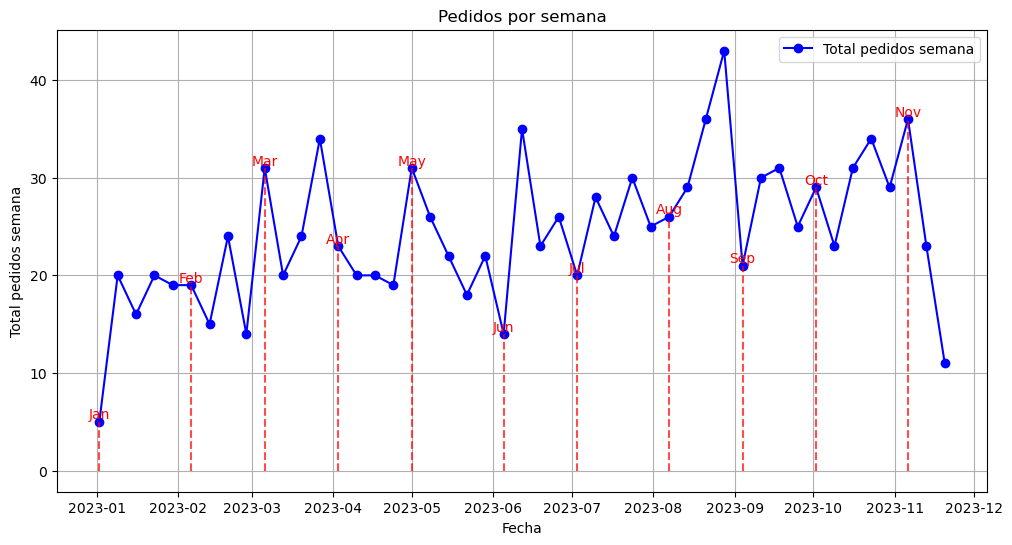

In [127]:
#PEDIDOS POR SEMANA DEL 2023
df_agrupado_semanal_2023[['InicioSemana', 'FinSemana']] = df_agrupado_semanal_2023['Semana'].str.split('/', expand=True)

# Convierte las columnas a formato datetime
df_agrupado_semanal_2023['InicioSemana'] = pd.to_datetime(df_agrupado_semanal_2023['InicioSemana'])
df_agrupado_semanal_2023['FinSemana'] = pd.to_datetime(df_agrupado_semanal_2023['FinSemana'])

# Calcula el ancho de las barras
bar_width = pd.to_timedelta(7, unit='D')  # ancho de una semana en días

# Crea el gráfico de línea y puntos
plt.figure(figsize=(12, 6))
plt.plot(df_agrupado_semanal_2023['InicioSemana'], df_agrupado_semanal_2023['Total_Pedidos_semana'], label='Total pedidos semana', color="b",marker='o')

for index, row in df_agrupado_semanal_2023.iterrows():
    if row['InicioSemana'].day <= 7:  # Verificar si es la primera semana del mes
        plt.vlines(row['InicioSemana'], 0, row['Total_Pedidos_semana'], colors='red',linestyles='dashed', alpha=0.7)
        plt.text(row['InicioSemana'], row['Total_Pedidos_semana'], f'{row["InicioSemana"].strftime("%b")}', ha='center', va='bottom', color='red')


# Configuraciones del gráfico
plt.title('Pedidos por semana')
plt.xlabel('Fecha')
plt.ylabel('Total pedidos semana')
plt.legend()
plt.grid(True)
plt.show()



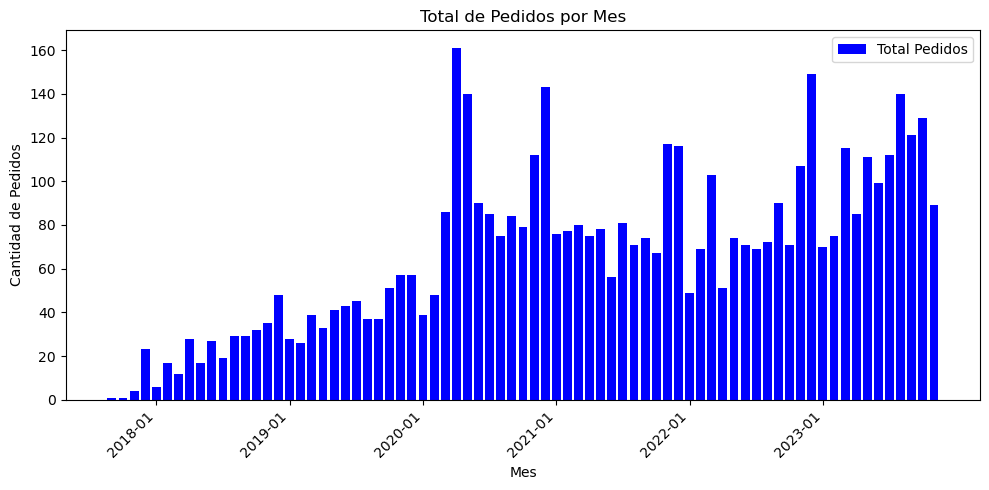

In [128]:
# VISUALIZAR TOTAL PEDIDOS POR MES HISTORICO
plt.figure(figsize=(10, 5))
plt.bar(df_agrupado_mensual['Mes'], df_agrupado_mensual['Total_Pedidos_mes'], color='blue', label='Total Pedidos')
plt.title('Total de Pedidos por Mes')
plt.xlabel('Mes')
plt.ylabel('Cantidad de Pedidos')
plt.xticks(df_agrupado_mensual['Mes'][4::12], rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

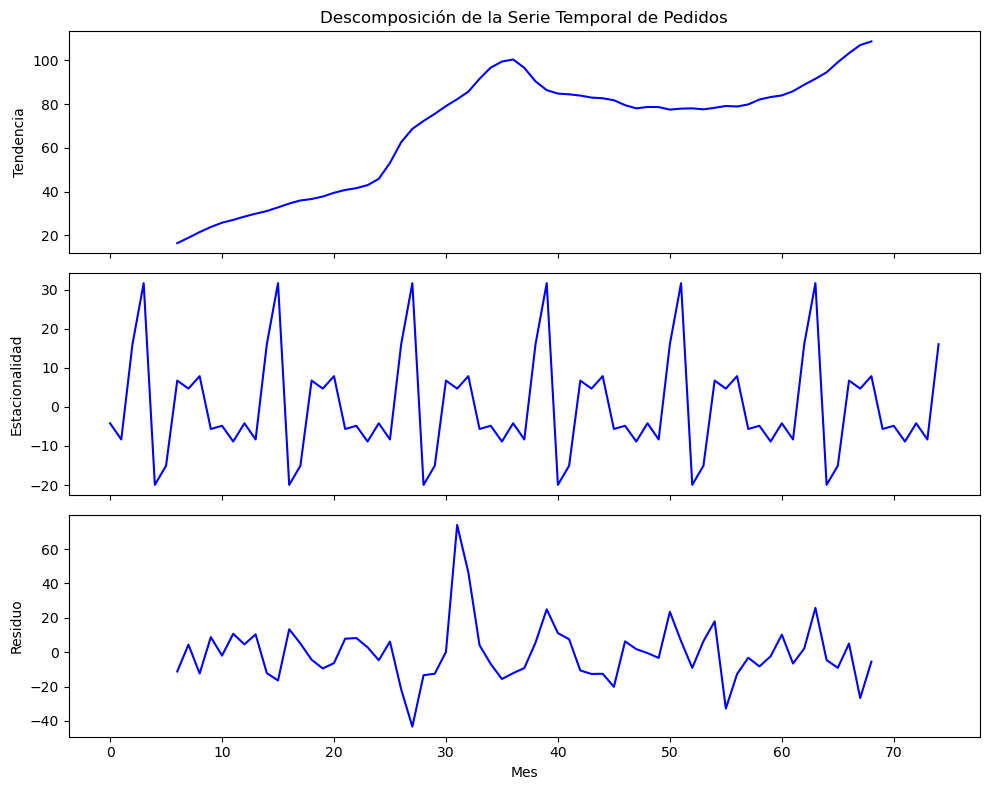

In [129]:
#COMPROBACIÓN DE TENDENCIA, ESTACIONALIDAD Y RUIDO EN PEDIDOS
descomposicion_pedidos = seasonal_decompose(df_agrupado_mensual['Total_Pedidos_mes'], model='additive', period=12)

# Configurar el color y ajustar el espaciado
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# Gráfico de la tendencia
descomposicion_pedidos.trend.plot(ax=ax1, color='blue')
ax1.set_ylabel('Tendencia')
ax1.set_title('Descomposición de la Serie Temporal de Pedidos')

# Gráfico de la estacionalidad
descomposicion_pedidos.seasonal.plot(ax=ax2, color='blue')
ax2.set_ylabel('Estacionalidad')

# Gráfico del residuo
descomposicion_pedidos.resid.plot(ax=ax3, color='blue')
ax3.set_ylabel('Residuo')

# Añadir etiquetas al eje x
ax3.set_xlabel('Mes')

plt.tight_layout()
plt.show()

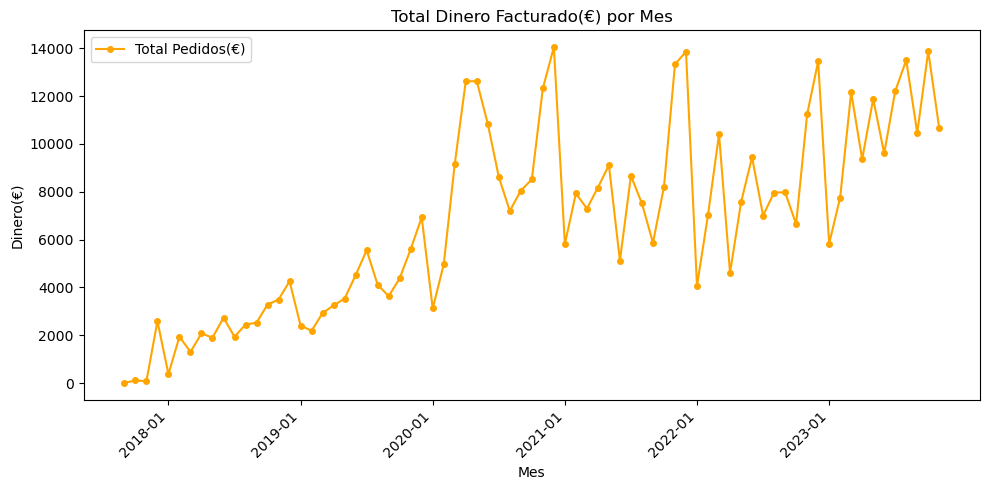

In [130]:
# VISUALIZAR TOTAL DINERO FACTURADO(€) POR MES
plt.figure(figsize=(10, 5))
plt.plot(df_agrupado_mensual['Mes'], df_agrupado_mensual['Total_Precios_mes'], color='orange', marker='o', markersize=4, label='Total Pedidos(€)')
plt.title('Total Dinero Facturado(€) por Mes')
plt.xlabel('Mes')
plt.ylabel('Dinero(€)')
plt.xticks(df_agrupado_mensual['Mes'][4::12], rotation=45, ha='right')
plt.tight_layout()
plt.legend()
plt.show()

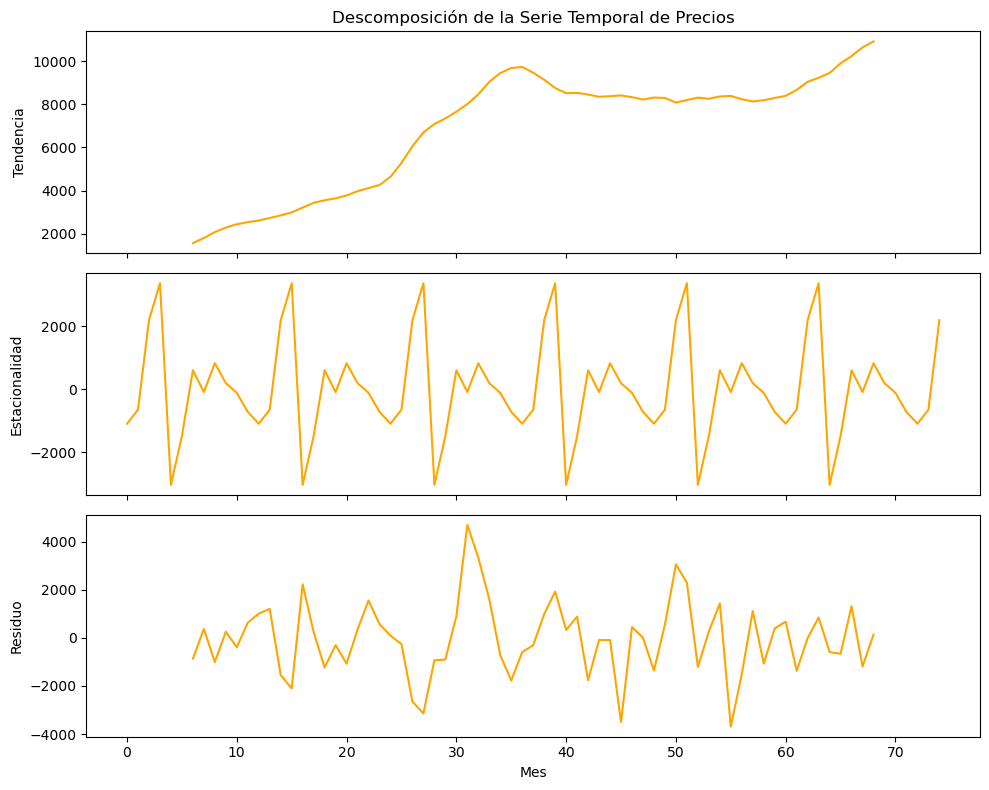

In [131]:
#COMPROBACIÓN DE TENDENCIA, ESTACIONALIDAD Y RUIDO EN DINERO FACTURADO
descomposicion_precios = seasonal_decompose(df_agrupado_mensual['Total_Precios_mes'], model='additive', period=12)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
descomposicion_precios.trend.plot(ax=ax1, color='orange')
ax1.set_ylabel('Tendencia')
ax1.set_title('Descomposición de la Serie Temporal de Precios')

descomposicion_precios.seasonal.plot(ax=ax2, color='orange')
ax2.set_ylabel('Estacionalidad')

descomposicion_precios.resid.plot(ax=ax3, color='orange')
ax3.set_ylabel('Residuo')
ax3.set_xlabel('Mes')

plt.tight_layout()
plt.show()


# **PREDICCIÓN PEDIDOS Y DINERO CON EL MODELO SARIMAX**

In [132]:
df_agrupado_mensual=transformar_timeseries_mensual(df)
df_agrupado_mensual.drop(74,axis=0, inplace=True)
df_agrupado_mensual['Mes'] = pd.to_datetime(df_agrupado_mensual['Mes'])
df_agrupado_mensual.set_index('Mes', inplace=True)
# Crear fechas futuras para la predicción (últimos 3 meses)
fecha_inicio_prediccion = df_agrupado_mensual.index[-4] + pd.DateOffset(months=1)
fecha_fin_prediccion = fecha_inicio_prediccion + pd.DateOffset(months=2)
fechas_prediccion = pd.date_range(fecha_inicio_prediccion, fecha_fin_prediccion, freq='MS')
# Dividir los datos en entrenamiento y prueba
train = df_agrupado_mensual.iloc[:-3]
test = df_agrupado_mensual.iloc[-3:]

# **ENCONTRAR MEJORES PARÁMETROS**

In [133]:
def mejores_parametros_sarimax(train, test,col1, p_values=range(4), d_values=range(3), q_values=range(4),
                                  P_values=range(3), D_values=[1], Q_values=range(3), s_values=[12]):
    # Crear las combinaciones de parámetros
    parameter_combinations = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, s_values))

    best_mse = float('inf')
    best_parameters = None

    # Grid search
    for params in parameter_combinations:
        order = params[:3]
        seasonal_order = params[3:]

        # Crear y entrenar modelo
        model = SARIMAX(train[col1], order=order, seasonal_order=seasonal_order)
        results = model.fit(disp=False)

        # Hacer las predicciones
        predictions = results.get_forecast(steps=len(test), exog=test[[col1]])
        y_pred = predictions.predicted_mean.values

        # Calcular el MSE
        mse = mean_squared_error(test[col1], y_pred)

        # Actualizar el mejor modelo
        if mse < best_mse:
            best_mse = mse
            best_parameters = params

    print(f"Best parameters found: {best_parameters} with MSE: {best_mse}")
    return best_parameters

In [134]:
#FUNCIÓN PARA ENCONTRAR LOS MEJORES PARÁMETROS. COMENTADA PORQUE TARDA MUCHO, SE PONEN MANUALMENTE POR TANTO
#mejores_parametros_pedidos = mejores_parametros_sarimax(train, test, 'Total_Pedidos_mes')

In [135]:
mejores_parametros_pedidos=(2,2,0,1,1,1,12)

In [136]:
def sarimax_coeficients(params, train_set, test_set):
    # Select the model and train
    order = params[:3]
    seasonal_order = params[3:]
    model = SARIMAX(train_set, order=order, seasonal_order=seasonal_order)
    results = model.fit(disp=False)


    exog_forecast = test_set
    predictions = results.get_forecast(steps=len(exog_forecast), exog=exog_forecast)

    return predictions.conf_int()
intervalos_pedidos=sarimax_coeficients(mejores_parametros_pedidos,train['Total_Pedidos_mes'], test[['Total_Pedidos_mes']])

In [137]:
intervalos_pedidos['media_pedidos'] = intervalos_pedidos[['lower Total_Pedidos_mes', 'upper Total_Pedidos_mes']].mean(axis=1)

In [138]:
# Establecer el índice de confidence_intervals con las fechas correspondientes
intervalos_pedidos.index = fechas_prediccion

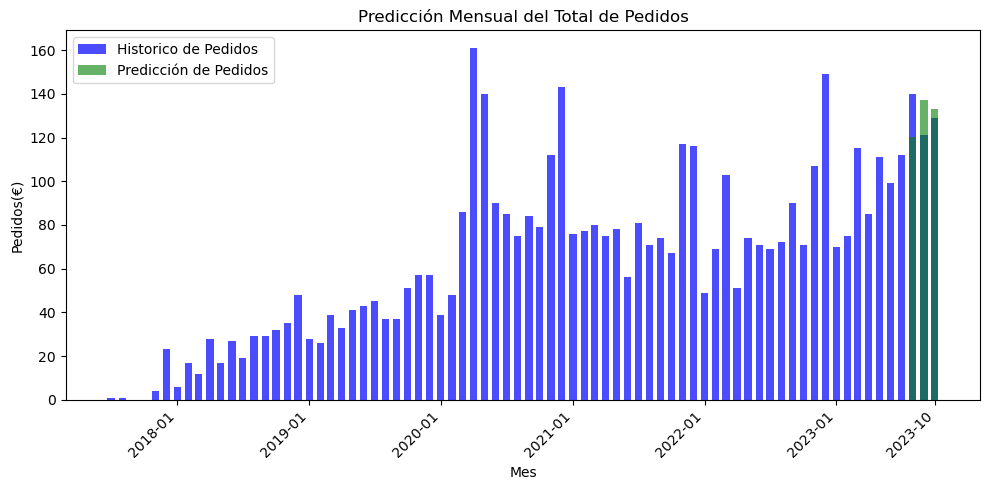

In [139]:
#COMPROBACIÓN DE PREDICCIÓN PEDIDOS MENSUALMENTE CON TRES MESES QUE YA TENEMOS: HASTA OCTUBRE
plt.figure(figsize=(10, 5))

# Histórico de Precios
plt.bar(df_agrupado_mensual.index, df_agrupado_mensual['Total_Pedidos_mes'], color='blue', label='Historico de Pedidos',alpha=0.7, width=20)
# Predicción de Precios
plt.bar(intervalos_pedidos.index, intervalos_pedidos['media_pedidos'], label='Predicción de Pedidos', color='green',alpha=0.6, width=20)


plt.title('Predicción Mensual del Total de Pedidos')
plt.xlabel('Mes')
plt.ylabel('Pedidos(€)')

# Formatear etiquetas del eje x para mostrar solo mes y año
date_fmt = mdates.DateFormatter('%Y-%m')
plt.gca().xaxis.set_major_formatter(date_fmt)

# Incluir etiquetas para las fechas de predicción en el eje x
etiquetas_x = list(df_agrupado_mensual.index[4::12]) + list(intervalos_pedidos.index[2::12])
plt.xticks(etiquetas_x, rotation=45, ha='right')

plt.tight_layout()
plt.legend()
plt.show()

In [140]:
#HACEMOS LO MISMO CON LOS PRECIOS
#FUNCIÓN PARA ENCONTRAR LOS MEJORES PARÁMETROS. COMENTADA PORQUE TARDA MUCHO, SE PONEN MANUALMENTE POR TANTO
#mejores_parametros_precios = mejores_parametros_sarimax(train, test, 'Total_Precios_mes')
mejores_parametros_precio = (2, 2, 0, 0, 1, 0, 12)
intervalos_precio=sarimax_coeficients(mejores_parametros_precio,train['Total_Precios_mes'], test[['Total_Precios_mes']])
intervalos_precio['media_precios'] = intervalos_precio[['lower Total_Precios_mes', 'upper Total_Precios_mes']].mean(axis=1)

In [141]:
intervalos_precio.index = fechas_prediccion

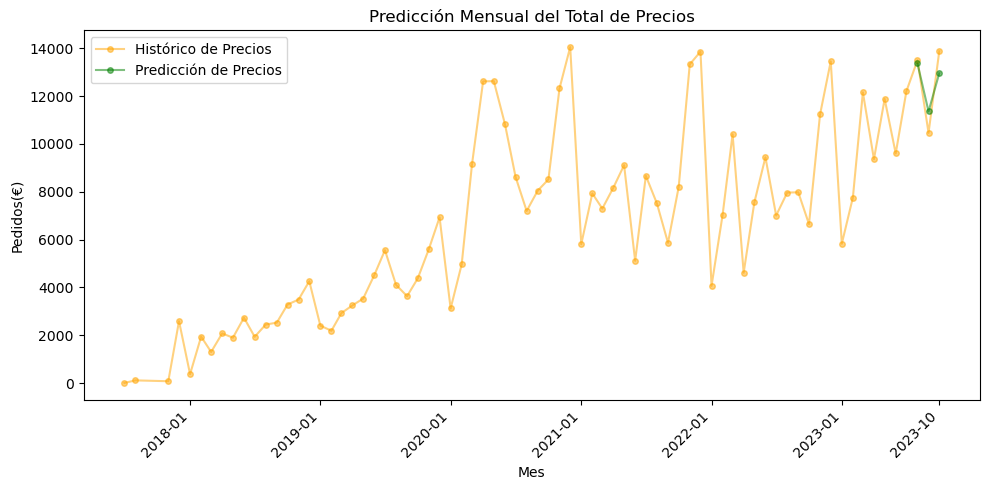

In [142]:
plt.figure(figsize=(10, 5))

plt.plot(df_agrupado_mensual.index, df_agrupado_mensual['Total_Precios_mes'], label='Histórico de Precios', marker='o', markersize=4, alpha=0.5, color='orange')

plt.plot(intervalos_precio.index, intervalos_precio['media_precios'], label='Predicción de Precios', color='green', marker='o', markersize=4, alpha=0.5)

plt.title('Predicción Mensual del Total de Precios')
plt.xlabel('Mes')
plt.ylabel('Pedidos(€)')

date_fmt = mdates.DateFormatter('%Y-%m')
plt.gca().xaxis.set_major_formatter(date_fmt)

etiquetas_x = list(df_agrupado_mensual.index[4::12]) + list(intervalos_precio.index[2::12])
plt.xticks(etiquetas_x, rotation=45, ha='right')

plt.tight_layout()
plt.legend()
plt.show()

# **PREDICCIONES 3 MESES FUTURO**

In [143]:
fecha_inicio_prediccion_fut = df_agrupado_mensual.index[-1] + timedelta(days=1)
primer_dia_proximo_mes_fut = pd.to_datetime(fecha_inicio_prediccion_fut) + pd.offsets.MonthBegin(1)
fecha_fin_prediccion_fut = primer_dia_proximo_mes_fut + pd.DateOffset(months=2)
fechas_prediccion_fut = pd.date_range(primer_dia_proximo_mes_fut, fecha_fin_prediccion_fut, freq='MS')

In [144]:
# Modelar y predecir el número de pedidos
model_pedidos_fut = SARIMAX(df_agrupado_mensual['Total_Pedidos_mes'], order=(2, 2, 0), seasonal_order=(1, 1, 1, 12))
results_pedidos_fut = model_pedidos_fut.fit()

# Hacer la predicción
prediccion_pedidos = results_pedidos_fut.get_forecast(steps=len(fechas_prediccion_fut))
prediccion_pedidos_ci = prediccion_pedidos.conf_int()

prediccion_pedidos_ci["fecha"]=fechas_prediccion_fut
prediccion_pedidos_ci.set_index("fecha", inplace=True)
prediccion_pedidos_ci['media_pedidos'] = prediccion_pedidos_ci[['lower Total_Pedidos_mes', 'upper Total_Pedidos_mes']].mean(axis=1)

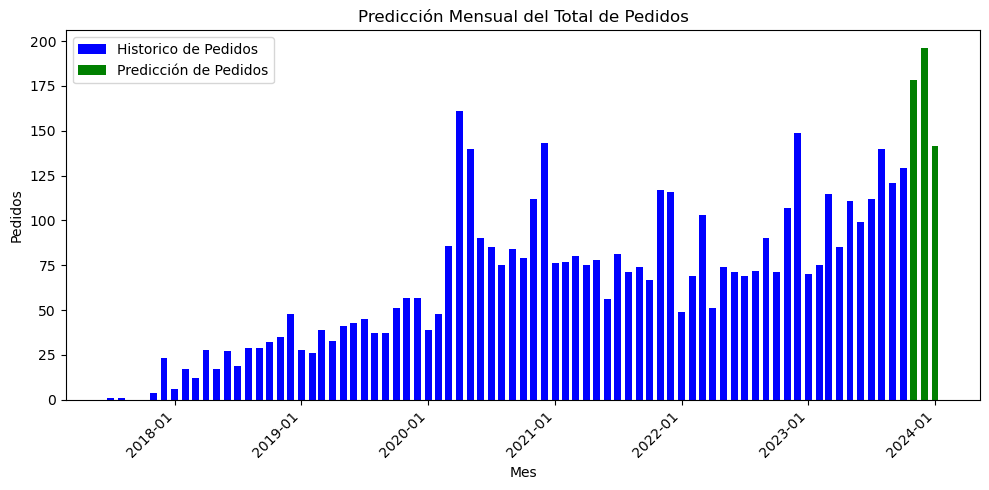

In [145]:
#PREDICCIÓN DE PEDIDOS A FUTURO
plt.figure(figsize=(10, 5))

# Histórico de Precios
plt.bar(df_agrupado_mensual.index, df_agrupado_mensual['Total_Pedidos_mes'], color='blue', label='Historico de Pedidos', width=20)
# Predicción de Precios
plt.bar(prediccion_pedidos_ci.index, prediccion_pedidos_ci['media_pedidos'], label='Predicción de Pedidos', color='green', width=20)
#plt.fill_between(prediccion_pedidos_ci.index, prediccion_pedidos_ci.iloc[:, 0], prediccion_pedidos_ci.iloc[:, 1], color='green', alpha=0.2)

plt.title('Predicción Mensual del Total de Pedidos')
plt.xlabel('Mes')
plt.ylabel('Pedidos')

# Formatear etiquetas del eje x para mostrar solo mes y año
date_fmt = mdates.DateFormatter('%Y-%m')
plt.gca().xaxis.set_major_formatter(date_fmt)

# Incluir etiquetas para las fechas de predicción en el eje x
etiquetas_x = list(df_agrupado_mensual.index[4::12]) + list(prediccion_pedidos_ci.index[2::12])
plt.xticks(etiquetas_x, rotation=45, ha='right')

plt.tight_layout()
plt.legend()
plt.show()

In [146]:
#MODELO PRECIOS 3 MESES A FUTURO
# Modelar y predecir el número de pedidos
model_precios_fut = SARIMAX(df_agrupado_mensual['Total_Precios_mes'], order=(2, 2, 0), seasonal_order=(1, 1, 1, 12))
results_precios_fut = model_precios_fut.fit()

# Hacer la predicción
prediccion_precios = results_precios_fut.get_forecast(steps=len(fechas_prediccion_fut))
prediccion_precios_ci = prediccion_precios.conf_int()

prediccion_precios_ci["fecha"]=fechas_prediccion_fut
prediccion_precios_ci.set_index("fecha", inplace=True)
prediccion_precios_ci['media_precios'] = prediccion_precios_ci[['lower Total_Precios_mes', 'upper Total_Precios_mes']].mean(axis=1)

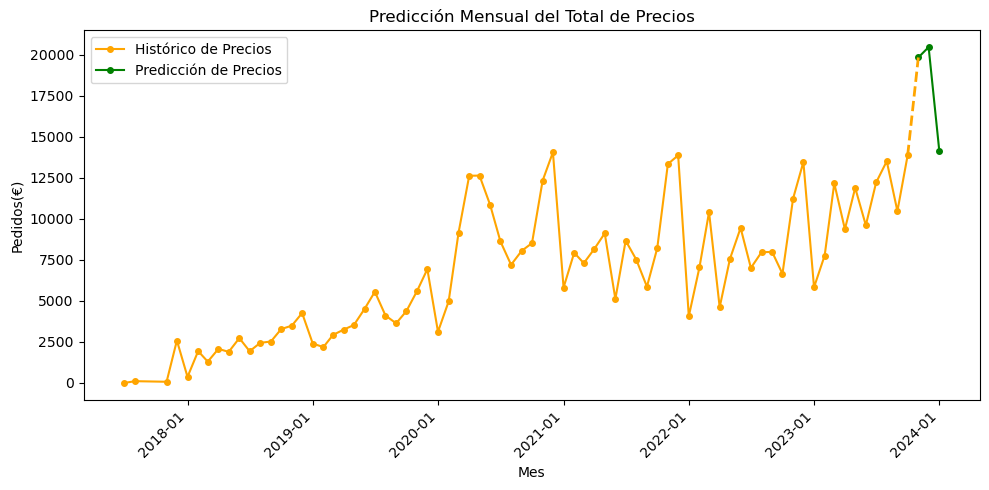

In [147]:
#PREDICCIÓN DE PRECIOS A FUTURO
plt.figure(figsize=(10, 5))

# Histórico de Precios
plt.plot(df_agrupado_mensual.index, df_agrupado_mensual['Total_Precios_mes'], label='Histórico de Precios', marker='o', markersize=4, color='orange')

# Predicción de Precios
plt.plot(prediccion_precios_ci.index, prediccion_precios_ci['media_precios'], label='Predicción de Precios', color='green', marker='o', markersize=4)

# Unir la línea de datos históricos con la línea de predicciones
plt.plot([df_agrupado_mensual.index[-1], prediccion_precios_ci.index[0]],
         [df_agrupado_mensual['Total_Precios_mes'].iloc[-1], prediccion_precios_ci['media_precios'].iloc[0]],
         linestyle='dashed', color='orange', linewidth=2)

plt.title('Predicción Mensual del Total de Precios')
plt.xlabel('Mes')
plt.ylabel('Pedidos(€)')

# Formatear etiquetas del eje x para mostrar solo mes y año
date_fmt = mdates.DateFormatter('%Y-%m')
plt.gca().xaxis.set_major_formatter(date_fmt)

# Incluir etiquetas para las fechas de predicción en el eje x
etiquetas_x = list(df_agrupado_mensual.index[4::12]) + list(prediccion_precios_ci.index[2::12])
plt.xticks(etiquetas_x, rotation=45, ha='right')

plt.tight_layout()
plt.legend()
plt.show()


# SEGMENTACIÓN DE CLIENTES: MODELO DE CLUSTERING

# NORMALIZACIÓN

In [148]:
#NORMALIZACIÓN
df_final_log=np.log1p(df_final[columnas_modelo])

# DBSCAN VS KMEANS

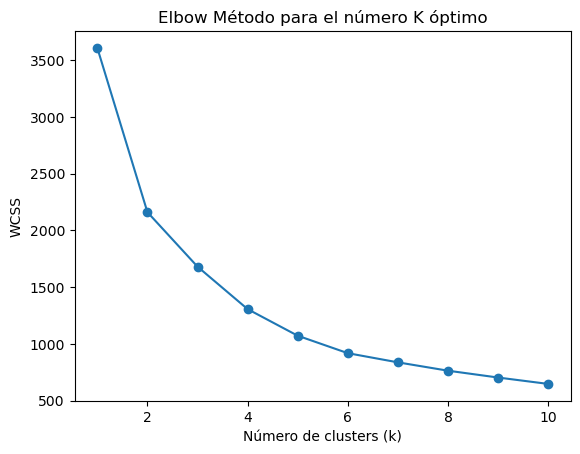

In [149]:
#ESCALADO
st_sc = StandardScaler()
scaled_features=st_sc.fit_transform(df_final_log)

#ENCONTRAR EL NÚMERO ÓPTIMO DE CLUSTERS
def calculate_wcss(data, max_k):
    wcss = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
    return wcss


max_k = 10

wcss_values = calculate_wcss(scaled_features, max_k)


plt.plot(range(1, max_k + 1), wcss_values, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Método para el número K óptimo')
plt.show()


In [150]:
#MODELO KMEANS
optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
df_final_log['KMeans_Cluster'] = kmeans.fit_predict(scaled_features)

In [151]:
#ENCONTRAR LOS PARÁMETROS IDEALES PARA DBSCAN

param_grid = {
    'eps': [0.1, 0.5, 1.0, 1.5],
    'min_samples': [3, 5, 10, 15]
}

silhouette_scores = []

for params in ParameterGrid(param_grid):
    dbscan_pa = DBSCAN(**params)
    labels = dbscan_pa.fit_predict(scaled_features)  # Assuming scaled_features is your feature array

    silhouette = silhouette_score(scaled_features, labels)  # Pass the labels, not the DataFrame

    silhouette_scores.append({'params': params, 'silhouette': silhouette})

best_params = max(silhouette_scores, key=lambda x: x['silhouette'])['params']

best_dbscan = DBSCAN(**best_params)
labels_best = best_dbscan.fit_predict(scaled_features)  # Assuming scaled_features is your feature array

print(f"Best DBSCAN Parameters: {best_params}")
print(f"Best Silhouette Score: {max(silhouette_scores, key=lambda x: x['silhouette'])['silhouette']}")

Best DBSCAN Parameters: {'eps': 1.5, 'min_samples': 3}
Best Silhouette Score: 0.6061622575526946


In [152]:
#MODELO DBSCAN
dbscan_final = DBSCAN(eps=1, min_samples=10)
df_final_log['DBSCAN_Cluster'] = dbscan_final.fit_predict(scaled_features)
num_clusters = len(set(df_final_log['DBSCAN_Cluster'])) - (1 if -1 in df_final_log['DBSCAN_Cluster'] else 0)
print(f"Número de clusters: {num_clusters}")


Número de clusters: 3


In [153]:
#SILHOUETTE PARA COMPARAR AMBOS
silhouette_kmeans = silhouette_score(scaled_features, df_final_log['KMeans_Cluster'])
print(f"Silhouette Score para KMeans: {silhouette_kmeans}")

silhouette_dbscan = silhouette_score(scaled_features, df_final_log['DBSCAN_Cluster'])
print(f"Silhouette Score para DBSCAN: {silhouette_dbscan}")

Silhouette Score para KMeans: 0.41063067178619506
Silhouette Score para DBSCAN: 0.38823131455269705


# OTROS MODELOS PARA EXPLICAR KMEANS

In [154]:
from sklearn.model_selection import train_test_split

colu = ['ultima_compra', 'conteo', 'precio_total_cliente']
X = df_final_log[colu]
Y = df_final_log['KMeans_Cluster']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.7)


In [155]:
rf = RandomForestClassifier()
rf.fit(X_train, Y_train)
y_pred_test = rf.predict(X_test)
accuracy_score(Y_test, y_pred_test)

0.9833795013850416

In [156]:
lr = LogisticRegression()
lr.fit(X_train, Y_train)
y_pred_test_lr = lr.predict(X_test)
accuracy_score(Y_test, y_pred_test_lr)

0.9750692520775623

In [157]:
xgb=XGBClassifier()
xgb.fit(X_train, Y_train)
y_pred_test_xgb = xgb.predict(X_test)
accuracy_score(Y_test, y_pred_test_xgb)

0.9861495844875346

# GRAFICOS DE CLUSTERS

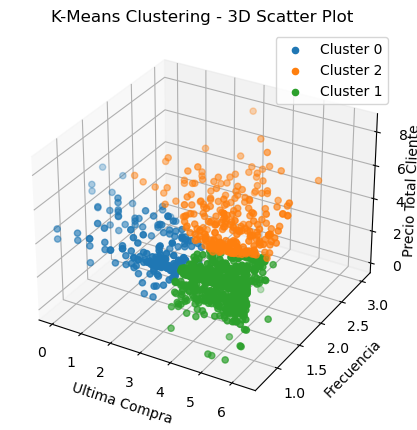

In [158]:
#SCATTER PLOT EN 3D PARA EXPLICAR CADA GRUPO
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111, projection='3d')

for cluster_label in df_final_log["KMeans_Cluster"].unique():
    cluster_data = df_final_log[df_final_log["KMeans_Cluster"] == cluster_label]
    ax.scatter(cluster_data[columnas_modelo[0]], cluster_data[columnas_modelo[1]], cluster_data[columnas_modelo[2]], label=f'Cluster {cluster_label}', cmap='viridis')

ax.legend()

ax.set_xlabel('Ultima Compra')
ax.set_ylabel('Frecuencia')
ax.set_zlabel('Precio Total Cliente', labelpad=-4)
ax.set_title('K-Means Clustering - 3D Scatter Plot')

plt.show()


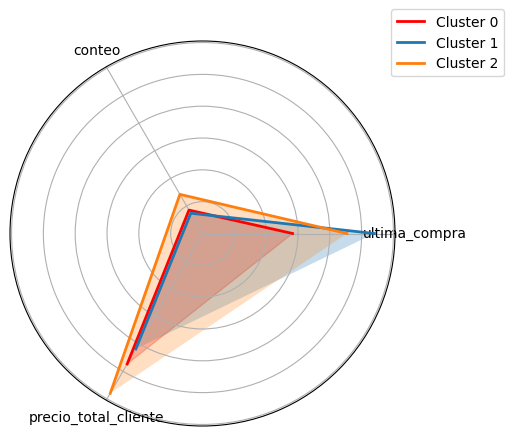

In [159]:
#RADAR GRAPH PARA EXPLICAR CADA CLÚSTER
legend_labels = [f"Cluster {i}" for i in sorted(df_final_log["KMeans_Cluster"].unique())]
features=["ultima_compra", "conteo", "precio_total_cliente"]
center=np.mean
centers = df_final_log.groupby("KMeans_Cluster")[features].agg(center)
n_clusters = len(centers)
num_features = len(features)
angles = np.linspace(0, 2 * np.pi, num_features, endpoint=False).tolist()
values = centers.values.tolist()
values += values[:1]
fig, ax = plt.subplots(figsize=(5,5), subplot_kw=dict(polar=True))
ax.plot(angles, values[0], color="r", linewidth=2, linestyle="solid", label=legend_labels[0])

for i in range(1, n_clusters):
    ax.plot(angles, values[i], linewidth=2, linestyle="solid", label=legend_labels[i])

ax.fill(angles, values[0], color="r", alpha=0.25)

for i in range(1, n_clusters):
    ax.fill(angles, values[i], alpha=0.25)

ax.set_yticklabels([])
ax.set_xticks(angles)
ax.set_xticklabels(features)

ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()


# **PLOT MAPA CLUSTERS**

In [160]:
df_final['KMeans_Cluster']=df_final_log['KMeans_Cluster']

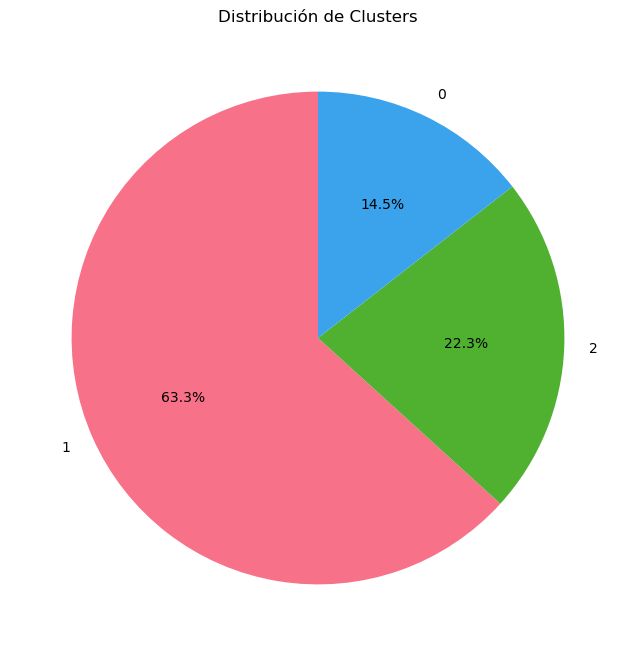

In [161]:
#PIE CHART CON LA SUMA DE CLIENTES POR CLUSTER
cluster_counts = df_final["KMeans_Cluster"].value_counts()
colors = sns.color_palette('husl', n_colors=len(cluster_counts))

plt.figure(figsize=(8, 8))
plt.pie(cluster_counts.values, labels=cluster_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Distribución de Clusters')
plt.show()


In [162]:
#CENTRO DE CADA CLUSTER CON LA MEDIA PARA EXPLICAR CADA GRUPO DE CLIENTES
df_final["KMeans_Cluster"]=df_final_log["KMeans_Cluster"]
graficar_centro=df_final.groupby("KMeans_Cluster")[columnas_modelo].agg(np.mean)
graficar_centro


,ultima_compra,conteo,precio_total_cliente
KMeans_Cluster,,,
0,23.431034,1.408046,140.528621
1,258.223390,1.107753,85.856163
2,135.291045,3.455224,440.476903


In [163]:
df_final.groupby("KMeans_Cluster")["precio_total_cliente"].sum()

KMeans_Cluster
0     24451.98
1     65336.54
2    118047.81
Name: precio_total_cliente, dtype: float64

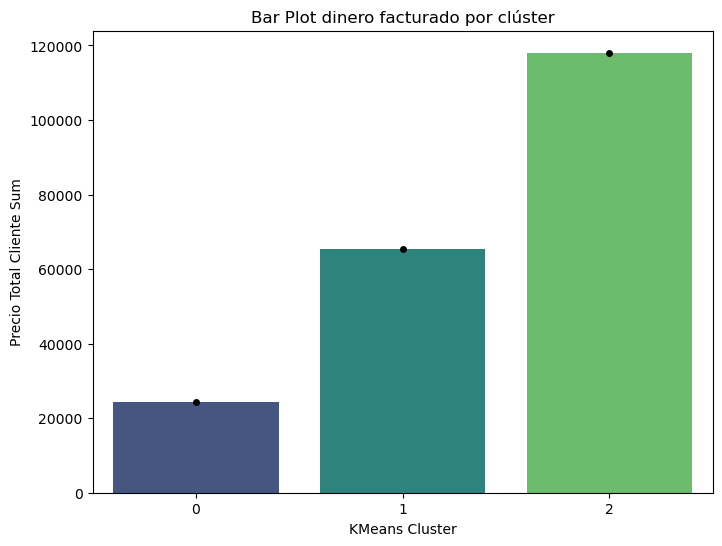

In [200]:
#GRAFICAR EL DINERO FACTURADO POR CADA CLÚSTER DE CLIENTES
grouped_df = df_final.groupby("KMeans_Cluster")["precio_total_cliente"].sum().reset_index()

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Create a bar plot with error bars
sns.barplot(x="KMeans_Cluster", y="precio_total_cliente", data=grouped_df, ci="sd", capsize=0.1, palette="viridis", ax=ax)

# Add individual data points with a strip plot
sns.stripplot(x="KMeans_Cluster", y="precio_total_cliente", data=grouped_df, color="black", size=5, jitter=True, ax=ax)

# Set labels and title
ax.set_xlabel('KMeans Cluster')
ax.set_ylabel('Precio Total Cliente Sum')
ax.set_title('Bar Plot dinero facturado por clúster')

plt.show()

In [165]:
df_mapa=df_final[["conteo", "codigo_postal", "KMeans_Cluster"]].copy()
df_mapa_unicos=df_mapa.groupby("codigo_postal")["conteo"].sum().reset_index()

In [166]:
df_mapa_cluster=df_mapa.groupby("codigo_postal").agg({'conteo': 'sum', 'KMeans_Cluster': 'first'}).reset_index()
df_mapa_cluster_0=df_mapa_cluster.query("KMeans_Cluster==0")
df_mapa_cluster_1=df_mapa_cluster.query("KMeans_Cluster==1")
df_mapa_cluster_2=df_mapa_cluster.query("KMeans_Cluster==2")

In [167]:
dicc_mapa_cluster_0=dict(zip(df_mapa_cluster_0["codigo_postal"], df_mapa_cluster_0["conteo"]))
dicc_mapa_cluster_1=dict(zip(df_mapa_cluster_1["codigo_postal"], df_mapa_cluster_1["conteo"]))
dicc_mapa_cluster_2=dict(zip(df_mapa_cluster_2["codigo_postal"], df_mapa_cluster_2["conteo"]))

In [168]:
#MAPA CLUSTER 1
crear_mapa(dicc_mapa_cluster_0, "green")

In [169]:
#MAPA CLUSTER 2
crear_mapa(dicc_mapa_cluster_1, "orange")

In [170]:
#MAPA CLUSTER 3
crear_mapa(dicc_mapa_cluster_2, "blue")

# SISTEMA DE RECOMENDACION

In [171]:
#LAS DOS COLUMNAS QUE VAMOS A USAR PARA EL SISTEMA DE RECOMENDACIÓN
#ID PEDIDO Y LA ID PESCADO (PRODUCTO)
col_recomendacion = ["id_pedido","id_pescado"]

In [172]:
df_recomendacion=df.copy()
df_reco = df_recomendacion[col_recomendacion]

In [173]:
#FUNCIÓN PARA AÑADIR UNA ETIQUETA DE SI SE HA COMPRADO EL PRODUCTO O NO
def add_purchase_indicator(df):
    all_combinations = pd.DataFrame([(i, j) for i in df['id_pedido'].unique() for j in range(26)],
                                    columns=['id_pedido', 'id_pescado'])

    merged_df = pd.merge(all_combinations, df, on=['id_pedido', 'id_pescado'], how='left')

    mark_as_purchased = lambda row: 1 if row['id_pescado'] in df_reco[df_reco['id_pedido'] == row['id_pedido']]['id_pescado'].values else 0
    merged_df["purchased"]=merged_df.apply(mark_as_purchased, axis=1)

    return merged_df

result_df = add_purchase_indicator(df_reco)


In [177]:
#CROSSVALIDACIÓN
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import SVD
data = Dataset.load_from_df(result_df[["id_pedido","id_pescado", "purchased"]], reader)
trainset, testset = train_test_split(data, test_size=0.2)
algo = SVD(n_factors=5,)
algo.fit(trainset)

In [178]:
#CROSSVALIDACIÓN
reader = Reader(rating_scale=(0, 1))

data = Dataset.load_from_df(result_df[["id_pedido", "id_pescado", "purchased"]], reader)

trainset, testset = train_test_split(data, test_size=0.2)

algo = SVD(n_factors=5)
algo.fit(trainset)


In [179]:
predictions = algo.test(testset)

In [180]:
accuracy.rmse(predictions)

RMSE: 0.2810


0.28102423898399675

In [181]:
#MOSTRAR LA ID DEL PEDIDO CON SU PRODUCTO RECOMENDADO Y SU VALORACIÓN
top_n_recommendations = [(pred.uid, pred.iid, pred.est) for pred in predictions]
top_n_recommendations.sort(key=lambda x: x[2], reverse=True)
top_n_recommendations = top_n_recommendations[:5]

for uid, iid, est in top_n_recommendations:
    print(f"pedido {uid} deberia considerar {iid} con rating: {est}")

pedido 8319 deberia considerar 2 con rating: 1
pedido 8319 deberia considerar 2 con rating: 1
pedido 8319 deberia considerar 2 con rating: 1
pedido 8319 deberia considerar 2 con rating: 1
pedido 8319 deberia considerar 0 con rating: 0.9338777977101143


In [182]:
recom=[(pred.uid, pred.iid, pred.est) for pred in predictions]

In [183]:
recom=pd.DataFrame(recom,columns=["id","id_prod","yhat"])

In [186]:
testSET=pd.DataFrame(testset,columns=["id","id_prod","y"])

In [187]:
recom.y=testSET.y

# CLUSTERING POR PRODUCTOS. ANALIZAR SI HAY UN PATRÓN DE COMPRA

In [188]:
df_pivot=df[['id_pedido','id_pescado','cantidad_producto']]

In [189]:
df_pivot=df_pivot.pivot_table(index='id_pedido', columns="id_pescado",values='cantidad_producto').fillna(0)

In [190]:
#PIVOT PARA QUEDARNOS CON LOS PRODUCTOS DE CADA ID PEDIDO
column_rename_dict = {str(old_column): str(int(float(old_column))) for old_column in df_pivot.columns}


df_pivot.rename(columns=column_rename_dict, inplace=True)

In [191]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('kmeans', KMeans(init='k-means++', random_state=42))
])

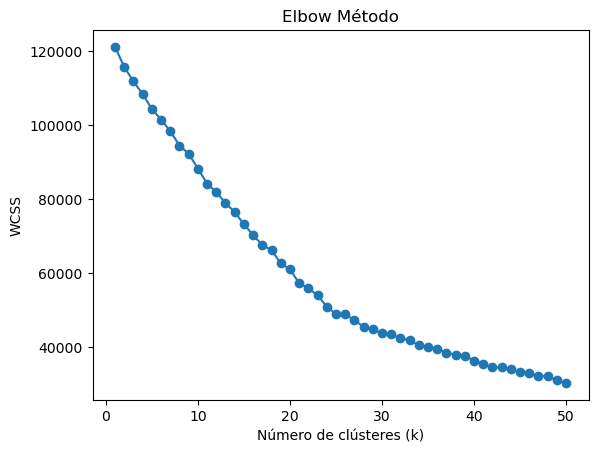

In [192]:
st_sc = StandardScaler()
scaled_features=st_sc.fit_transform(df_pivot)

def calculate_wcss(data, max_k):
    wcss = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
    return wcss


max_k = 50

wcss_values = calculate_wcss(scaled_features, max_k)


plt.plot(range(1, max_k + 1), wcss_values, marker='o')
plt.xlabel('Número de clústeres (k)')
plt.ylabel('WCSS')
plt.title('Elbow Método')
plt.show()

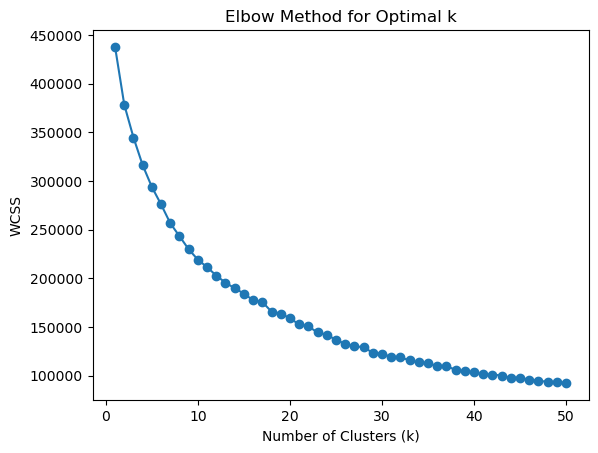

In [193]:
def calculate_wcss(data, max_k):
    wcss = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
    return wcss


max_k = 50

wcss_values = calculate_wcss(df_pivot, max_k)


plt.plot(range(1, max_k + 1), wcss_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal k')
plt.show()

In [194]:
#KMEANS PARA LAS COMBINACIONES DE PRODUCTOS
optimal_k_prod = 15

kmeans_prod = KMeans(n_clusters=optimal_k_prod, init='k-means++', random_state=42)
df_pivot['KMeans_Cluster'] = kmeans_prod.fit_predict(df_pivot)

In [195]:
#SACAMOS EL NÚMERO DE LOS CINCO CLUSTERS MÁS GRANDES
cluster_counts = df_pivot["KMeans_Cluster"].value_counts()
cluster_labels = cluster_counts.index.tolist()

print(cluster_labels[:5])


[11, 2, 6, 8, 0]


# GRAFICAR CADA CLUSTER

In [196]:
def plot_cluster_producto(num):
    df_cluster_1 = df_pivot[df_pivot['KMeans_Cluster'] == num]
    df_cluster_1.drop('KMeans_Cluster', axis=1, inplace=True)
    column_sums = df_cluster_1.sum()

    # Create a bar plot
    plt.figure(figsize=(6, 4))
    column_sums.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f'Cluster {num}')
    plt.xlabel('Columnas')
    plt.ylabel('Suma')
    new_column_names = ["atun", "melva", "caballa", "jurel", "sardina", "boquerones", "anchoas", "sardinillas",
                            "surtido", "huevas de maruca", "huevas de bacalao", "ventresca", "calamares", "mojama", "mejillones",
                            "berberechos", "salmon", "hueva de maruca", "huevas bacalao", "boqueron", "bacalao", "anchoa", "caballitas",
                            "bonito", "gambas", "sal"]
    plt.xticks(range(len(new_column_names)), new_column_names, rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


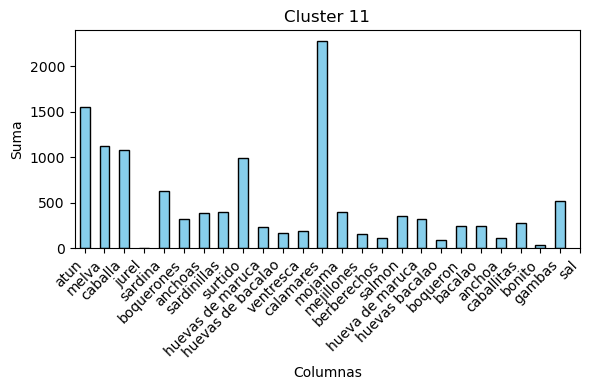

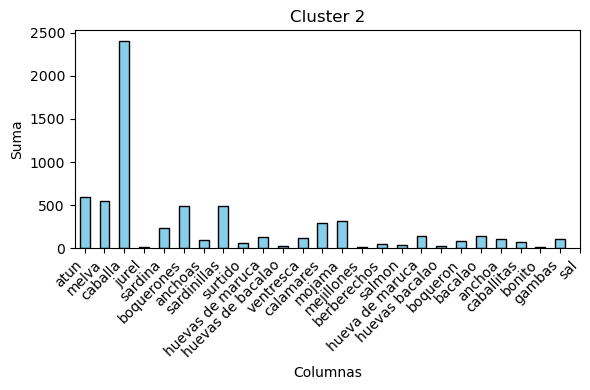

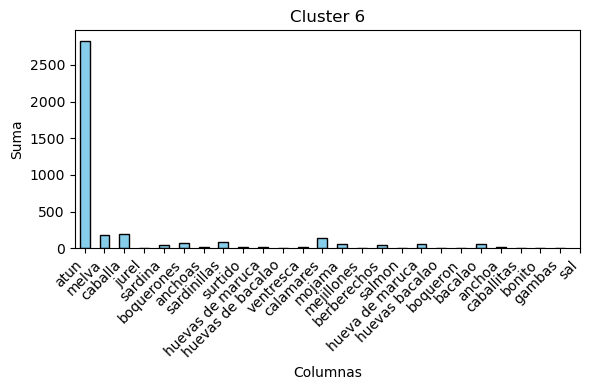

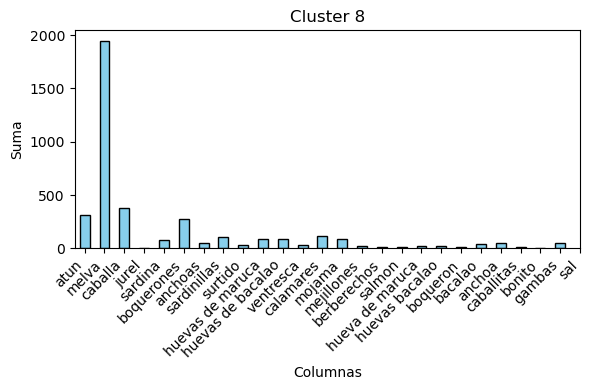

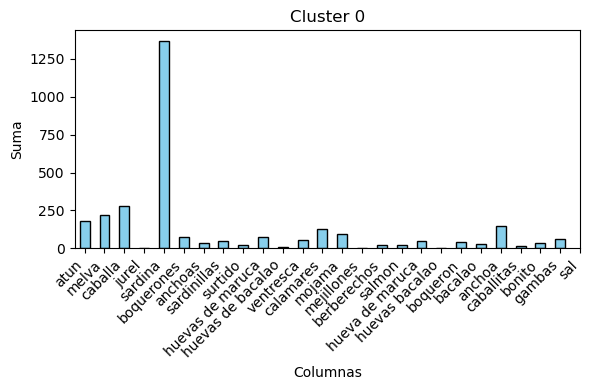

In [197]:
#ESCOGEMOS LOS 5 CLUSTERS MÁS GRANDES
for i in cluster_labels[:5]:
    plot_cluster_producto(i)